In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from multiprocessing.pool import Pool
import re
positive_file = 'data/rt-polarity.pos'
negative_file = 'data/rt-polarity.neg'
data_root = 'data/stanfordSentimentTreebank/'
glove_pattern = 'data/glove.6B.<size>d.txt'
glove_size = 300

In [2]:
glove_dict = None
def get_glove(size = 50):
    global glove_dict
    if glove_dict is None or len(list(glove_dict.values())[0]) != size:
        file = re.sub('<size>', str(size), glove_pattern)
        glove = pd.read_csv(file, sep = " ", header = None, index_col = 0, quoting = 3)
        glove_dict = {key: val.values for key, val in glove.T.items()}
    return glove_dict

def preprocess_sentence(line):
    line = re.sub(r'[^\x00-\x7F]+', '', line.strip())
    return line.strip().lower()

def preprocess_for_labels(line):
    line = preprocess_sentence(line)
    line = re.sub('\W+', '', line.strip())
    return line
    
def get_labelset(file):
    with open(file, "rt", encoding="utf-8") as f:
        sentences = set([preprocess_for_labels(line) for line in f.readlines()])
    return sentences

In [3]:
positive_labelset = get_labelset(positive_file)
negative_labelset = get_labelset(negative_file)

In [4]:
data_split_dict = {}
data_split_map = {'1': 'train', '2': 'test', '3':'val'}
with open(data_root + 'datasetSplit.txt', 'r') as f:
    for line in f.readlines():
        [index, set_code] = line.strip().split(',')
        try:
            index = int(index)
        except:
            continue
        if set_code not in data_split_map:
            print(index, set_code)
        data_split_dict[index] = data_split_map.get(set_code, 'val')

In [5]:
def check_sentiment(sentence):
    s = preprocess_for_labels(sentence)
    for y, labelset in enumerate([negative_labelset, positive_labelset]):
        for entry in labelset:
            if s in labelset:
                return y
    return -1

sentences = {}
word2ind = {}
ttws = tf.keras.preprocessing.text.text_to_word_sequence
n_skipped = 0
idx = 0
with open(data_root + 'datasetSentences.txt') as data:
    lines = data.readlines()
    for line in lines:
        index = re.search('^\d+', line)
        if index is None:
            continue
        index = int(index.group())
        if index not in data_split_dict:
            print(index, line)
        entry = {'split_set': data_split_dict.get(index, 'val')}
        line = preprocess_sentence(line)
        line = re.sub(r'^\d+\s+', '', line)
        sentiment = check_sentiment(line)
        if sentiment >= 0:
            entry['y'] = sentiment
        else:
            n_skipped += 1
            continue
        sentences[line] = entry
        tokens = ttws(line)
        for token in tokens:
            if token not in word2ind:
                word2ind[token] = idx
                idx = idx + 1

In [6]:
print(n_skipped, ' skipped')
print(len(sentences), ' kept')

2775  skipped
9077  kept


In [7]:
data_splits = {title: {'x':[], 'y':[]} for title in ['train', 'test', 'val']}
for line, entry in sentences.items():
    which = entry['split_set']
    tokenized = [int(word2ind[token]) for token in ttws(line)]
    (data_splits[which]['x']).append(tokenized)
    (data_splits[which]['y']).append(int(entry['y']))

In [8]:
for title in ['train', 'test', 'val']:
    print(title + ' dataset size:', len(data_splits[title]['x']))

train dataset size: 6530
test dataset size: 1702
val dataset size: 845


In [ ]:
def get_dataset(label, sequence_len):
    vals = data_splits[label]
    x = [np.array(vx) for vx in vals['x']]
    x = tf.keras.preprocessing.sequence.pad_sequences(x,
                                                      padding = 'post',
                                                      maxlen = sequence_len)
    y = np.array(vals['y'])
    return x, y

In [ ]:
def get_embedding_matrix(glove_size):
    glove = get_glove(glove_size)
    glove_words = set(glove.keys())
    default_vector = np.mean(list(glove.values()), axis = 0)
    embedding_matrix = np.empty((len(word2ind), default_vector.shape[0]))
    for word, position in word2ind.items():
        embedding_matrix[position,:] = glove.get(word, default_vector)
    return embedding_matrix


### 2.1 Define Network Models

In [ ]:
class CNNModel(tf.keras.Model):
    
    def __init__(self, embedding = 300, 
                 train_embeddings = True, 
                 pretrained_embedding = False, 
                 vocab_size = None,
                 filter_windows = [3,4,5],
                 feature_maps = 100,
                 dropout_rate = .5,
                 l2_constraint = 3):
        super(CNNModel, self).__init__()
        if pretrained_embedding:
            embedding_matrix = get_embedding_matrix(embedding)
            embedding_initializer = tf.keras.initializers.Constant(embedding_matrix)
        else:
            embedding_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed = 1)
        if vocab_size is None:
            vocab_size = len(word2ind)
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding, 
            embeddings_initializer= embedding_initializer,
            trainable = train_embeddings)
        self.filters = [tf.keras.layers.Conv1D(feature_maps, fw, activation = 'relu') for fw in filter_windows]
        self.max_pools = [tf.keras.layers.GlobalMaxPool1D() for f in self.filters]
        self.get_filters = lambda : zip(self.filters, self.max_pools)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.concat = tf.keras.layers.Concatenate(axis=1)
        self.logistic = tf.keras.layers.Dense(1, activation = 'sigmoid', kernel_constraint=tf.keras.constraints.max_norm(l2_constraint))
        
    def call(self, inputs, training = False):
        x = self.embedding(inputs)
        filter_outputs = []
        for f,p in self.get_filters():
            out = f(x)
            filter_outputs.append(p(out))
        x = self.concat(filter_outputs)
        if training:
            x = self.dropout(x)
        return self.logistic(x)
            
def compile_model(model, lr, model_args = {}, metrics = ['BinaryAccuracy']):
    net = model(**model_args)
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    net.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = metrics)
    return net

def run_model(model_type = CNNModel, verbose = 2, epochs = 100, batch_size = 50, 
              sequence_len = 45, learning_rate = .001, model_args = {}):
    (xtrain, ytrain)= get_dataset('train', sequence_len)
    (xval, yval) = get_dataset('val', sequence_len)
    model = compile_model(model_type, learning_rate, model_args)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience=10, 
                                                   restore_best_weights = True)
    train_history = model.fit(xtrain, ytrain, callbacks = [es_callback], validation_data = (xval, yval), batch_size = batch_size, epochs = epochs, verbose = verbose)
    return train_history

### 2.2 Run a basic CNN Model

In [ ]:
rand_params = {}
rand_hist = run_model(model_args = rand_params)

W1106 00:09:08.950222  6940 deprecation.py:506] From F:\Anaconda\lib\site-packages\tensorflow\python\keras\initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1106 00:09:08.952222  6940 deprecation.py:506] From F:\Anaconda\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1106 00:09:09.281241  6940 deprecation.py:323] From F:\Anaconda\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a futur

Train on 6530 samples, validate on 845 samples
Epoch 1/100
6530/6530 - 15s - loss: 0.6259 - binary_accuracy: 0.6383 - val_loss: 0.5126 - val_binary_accuracy: 0.7456
Epoch 2/100
6530/6530 - 15s - loss: 0.3093 - binary_accuracy: 0.8804 - val_loss: 0.4969 - val_binary_accuracy: 0.7775
Epoch 3/100
6530/6530 - 15s - loss: 0.0865 - binary_accuracy: 0.9778 - val_loss: 0.5962 - val_binary_accuracy: 0.7621
Epoch 4/100
6530/6530 - 15s - loss: 0.0220 - binary_accuracy: 0.9966 - val_loss: 0.7199 - val_binary_accuracy: 0.7550
Epoch 5/100
6530/6530 - 15s - loss: 0.0072 - binary_accuracy: 0.9998 - val_loss: 0.7614 - val_binary_accuracy: 0.7586
Epoch 6/100
6530/6530 - 15s - loss: 0.0034 - binary_accuracy: 1.0000 - val_loss: 0.8090 - val_binary_accuracy: 0.7621
Epoch 7/100
6530/6530 - 15s - loss: 0.0021 - binary_accuracy: 1.0000 - val_loss: 0.8459 - val_binary_accuracy: 0.7633
Epoch 8/100
6530/6530 - 15s - loss: 0.0015 - binary_accuracy: 1.0000 - val_loss: 0.8761 - val_binary_accuracy: 0.7609
Epoch 9/1

In [ ]:
static_params = {'pretrained_embedding': True, 'train_embeddings': False}
static_hist = run_model(model_args = static_params)

Train on 6530 samples, validate on 845 samples
Epoch 1/100
6530/6530 - 6s - loss: 0.5411 - binary_accuracy: 0.7175 - val_loss: 0.4578 - val_binary_accuracy: 0.7763
Epoch 2/100
6530/6530 - 6s - loss: 0.3206 - binary_accuracy: 0.8784 - val_loss: 0.4399 - val_binary_accuracy: 0.7953
Epoch 3/100
6530/6530 - 6s - loss: 0.1991 - binary_accuracy: 0.9524 - val_loss: 0.4544 - val_binary_accuracy: 0.7893
Epoch 4/100
6530/6530 - 5s - loss: 0.1095 - binary_accuracy: 0.9884 - val_loss: 0.4679 - val_binary_accuracy: 0.8000
Epoch 5/100
6530/6530 - 5s - loss: 0.0587 - binary_accuracy: 0.9974 - val_loss: 0.4956 - val_binary_accuracy: 0.7870
Epoch 6/100
6530/6530 - 5s - loss: 0.0322 - binary_accuracy: 0.9991 - val_loss: 0.4986 - val_binary_accuracy: 0.7964
Epoch 7/100
6530/6530 - 5s - loss: 0.0192 - binary_accuracy: 0.9998 - val_loss: 0.5187 - val_binary_accuracy: 0.7941
Epoch 8/100
6530/6530 - 5s - loss: 0.0129 - binary_accuracy: 1.0000 - val_loss: 0.5331 - val_binary_accuracy: 0.7953
Epoch 9/100
6530/

In [ ]:
nonstatic_params = {'pretrained_embedding': True, 'train_embeddings': True}
nonstatic_hist = run_model(model_args = nonstatic_params)

Train on 6530 samples, validate on 845 samples
Epoch 1/100
6530/6530 - 14s - loss: 0.5249 - binary_accuracy: 0.7328 - val_loss: 0.4487 - val_binary_accuracy: 0.7811
Epoch 2/100
6530/6530 - 14s - loss: 0.2360 - binary_accuracy: 0.9225 - val_loss: 0.4376 - val_binary_accuracy: 0.7953
Epoch 3/100
6530/6530 - 14s - loss: 0.0884 - binary_accuracy: 0.9862 - val_loss: 0.4921 - val_binary_accuracy: 0.7988
Epoch 4/100
6530/6530 - 14s - loss: 0.0314 - binary_accuracy: 0.9988 - val_loss: 0.4967 - val_binary_accuracy: 0.8249
Epoch 5/100
6530/6530 - 14s - loss: 0.0125 - binary_accuracy: 0.9998 - val_loss: 0.5297 - val_binary_accuracy: 0.8130
Epoch 6/100
6530/6530 - 14s - loss: 0.0067 - binary_accuracy: 1.0000 - val_loss: 0.5613 - val_binary_accuracy: 0.8118
Epoch 7/100
6530/6530 - 14s - loss: 0.0043 - binary_accuracy: 1.0000 - val_loss: 0.5935 - val_binary_accuracy: 0.8166
Epoch 8/100
6530/6530 - 14s - loss: 0.0030 - binary_accuracy: 1.0000 - val_loss: 0.6078 - val_binary_accuracy: 0.8036
Epoch 9/1

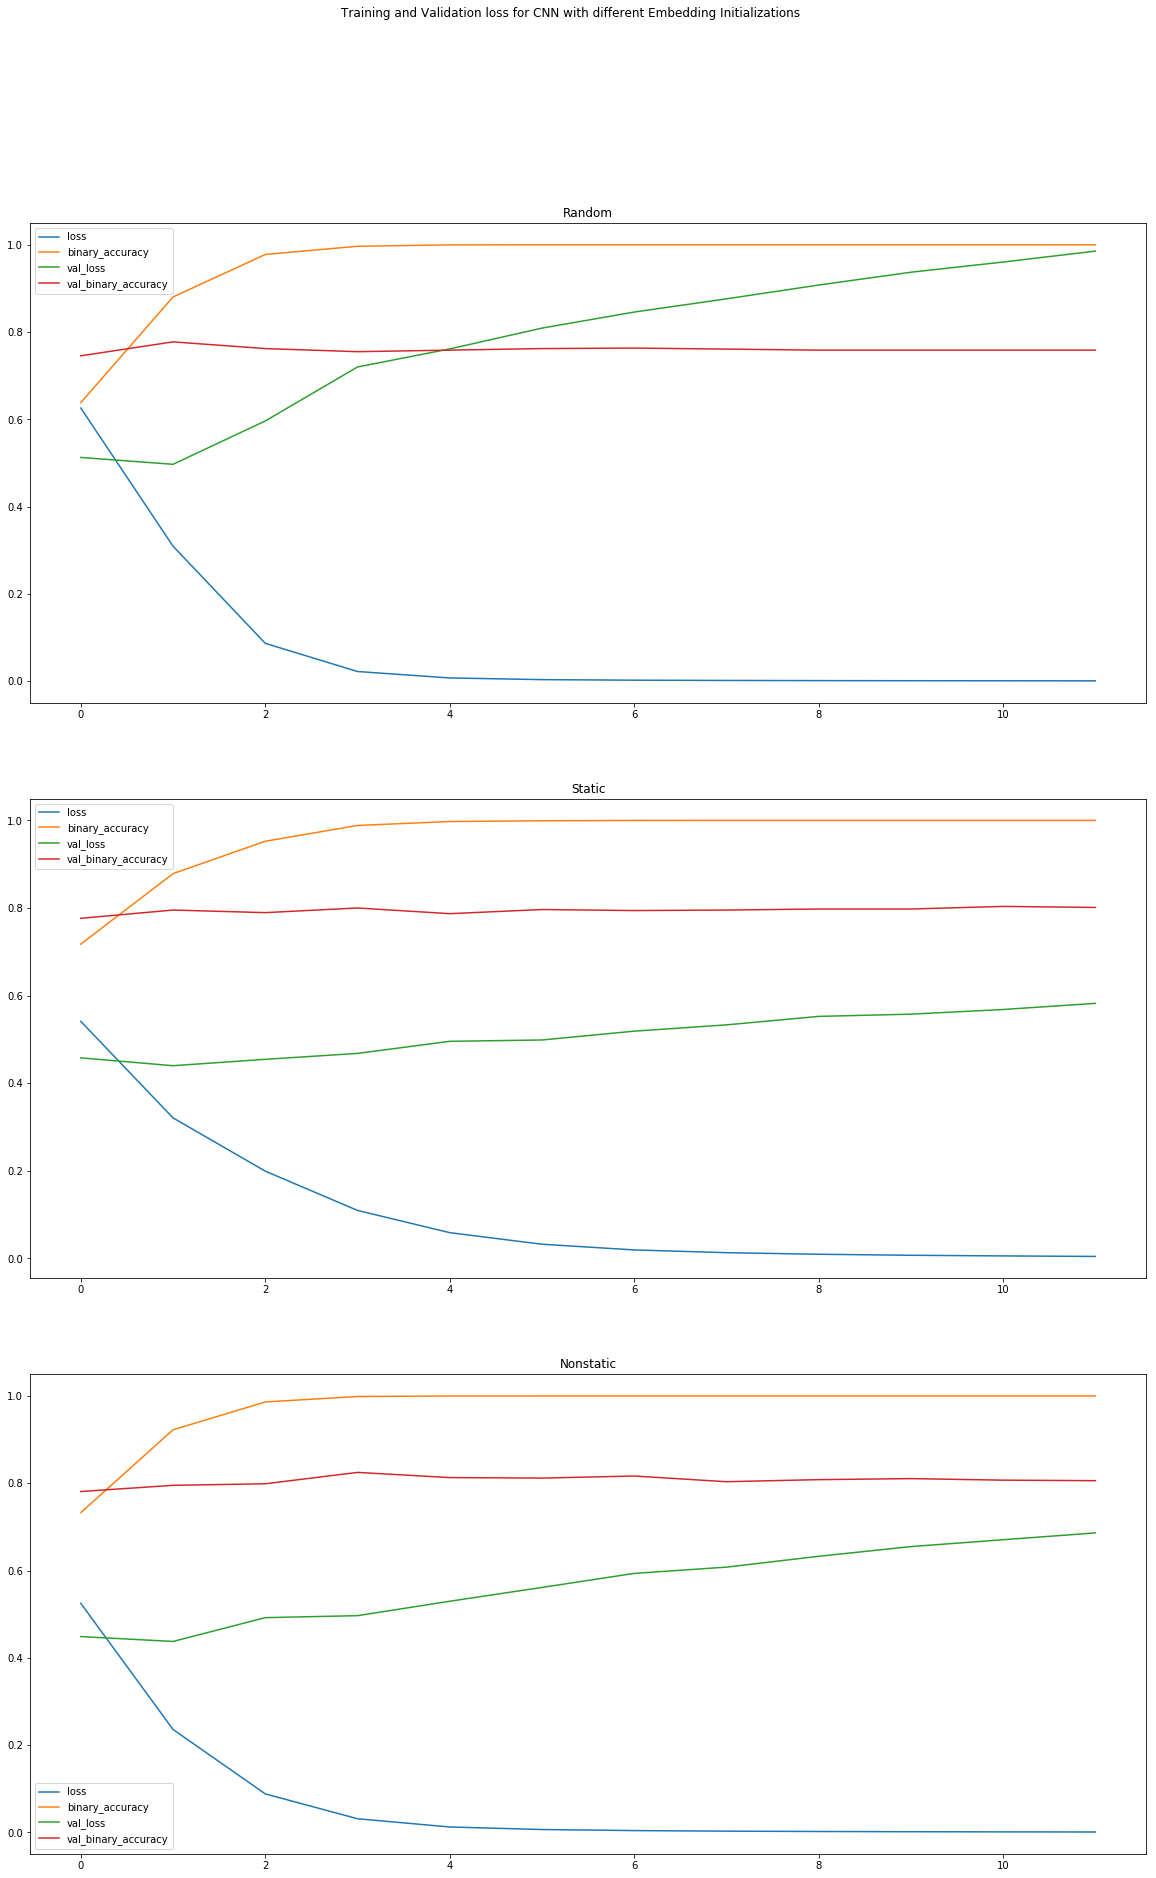

In [ ]:
def plot_history(histories, title = None, sub_titles = None, width = 2, plot_metrics = None):
    if plot_metrics is not None:
        plot_metrics += ['val_' + m for m in plot_metrics]
    else:
        plot_metrics = list(histories[0].history.keys())
    histories = [h.history for h in histories]
    n_plots = len(histories)
    options = {'figsize': [20,30]}
    fig, ax = plt.subplots(n_plots, **options)
    if title is not None:
        fig.suptitle(title)
    for i in range(n_plots):
        history = histories[i]
        for key in plot_metrics:
            vals = history[key]
            ax[i].plot(range(len(vals)), vals, label=key)
            if sub_titles is not None:
                ax[i].set_title(sub_titles[i])
        if len(history.keys()) > 1:
            ax[i].legend()
histories = [rand_hist, static_hist, nonstatic_hist]
plot_history(histories,
             title = 'Training and Validation loss for CNN with different Embedding Initializations',
             sub_titles = ['Random', 'Static', 'Nonstatic'])

In [ ]:
def best_timestep(history, metric_name = 'val_binary_accuracy', big_good = True):
    values = history.history[metric_name]
    evals = [np.mean( values[np.max([i-1,0]): np.min([i+1,len(values)-1])] ) for i in range(len(values))]
    if not big_good:
        evals = [-i for i in evals]
    best_itter = np.argmax(evals)
    best_val = values[best_itter]
    result = {key: value[best_itter] for key, value in history.history.items() if re.search('val_', key) is not None}
    result['itter'] = best_itter
    return result
[best_timestep(h) for h in histories]

[{'val_loss': 0.5962261264846169,
  'val_binary_accuracy': 0.7621302,
  'itter': 2},
 {'val_loss': 0.582226701389403,
  'val_binary_accuracy': 0.8011834,
  'itter': 11},
 {'val_loss': 0.5296788517187333,
  'val_binary_accuracy': 0.8130177,
  'itter': 4}]

In [ ]:
def find_best_model(model_args, seq_len = 50, epochs = 40):
    xtrain, ytrain = get_dataset('train', seq_len)
    xval, yval = get_dataset('val', seq_len)
    best_score = 0
    best_model = None
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                patience=4, 
                                restore_best_weights = True)
    for dropout in [.5, .7, .8, .9,]:
        model_args['dropout_rate'] = dropout
        model = compile_model(CNNModel, .01, model_args, 
                              ['BinaryAccuracy','Precision','Recall'])
        hist = model.fit(xtrain, ytrain,
                  validation_data = (xval, yval),
                  callbacks = [es_callback],
                  batch_size = 50,
                  epochs = epochs,
                  verbose = 0)
        score = np.max(hist.history['val_binary_accuracy'])
        if score > best_score:
            best_score = score
            best_model = model
            print(dropout, score)
    return best_model

def evaluate_best_model(model_args):
    model = find_best_model(model_args)
    xtest, ytest = get_dataset('test', 50)
    [eval_loss, eval_acc, eval_precision, eval_recall] = model.evaluate(xtest, ytest)
    f1_score = 2*eval_precision*eval_recall/(eval_precision + eval_recall)
    result = {'precision': eval_precision, 'recall': eval_recall, 'f1_score': f1_score}
    return result

In [ ]:
result_dict = {}
for name, params in zip(['random', 'static', 'nonstatic'], [rand_params, static_params, nonstatic_params]):
    results = evaluate_best_model(params)
    result_dict[name] = results
    print(name, results)

0.5 0.75739646
1702/1702 [==============================] - 1s 367us/sample - loss: 0.5110 - binary_accuracy: 0.7456 - precision: 0.7186 - recall: 0.8237
random {'precision': 0.71859294, 'recall': 0.82373273, 'f1_score': 0.7675791369946892}
0.5 0.76804733
0.7 0.7692308
0.8 0.7810651
1702/1702 [==============================] - 1s 384us/sample - loss: 0.4841 - binary_accuracy: 0.7709 - precision_12: 0.7728 - recall_12: 0.7800
static {'precision': 0.772831, 'recall': 0.7799539, 'f1_score': 0.7763761229842573}
0.5 0.78698224
0.7 0.7881657


In [ ]:
result_df = pd.DataFrame(result_dict).T
result_df

In [ ]:
result_df.T.plot(kind='barh')